# CIFAR100 transfer
Exploring applicability of models trained on CIFAKE for 'real' images

In [1]:
import torch
import numpy as np
import json 

from classes import CI_LOADER, CIFAKE_CNN
from test import test_model, test_thresh_size, visualise, score_content_preds

with open('./config.json') as f:
    config = json.load(f)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <EA7F9DF5-8854-31D8-89D4-BD566CAF4DEA> /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <03BFC270-EF54-36FC-B102-371F5164D3C9> /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
def find_extrema(df):
    return df.loc[[df.idxmax()[0]]], df.loc[[df.idxmin()[0]]]

### Data loading

In [3]:
# The CIFAR-100 dataset consists of 60000 32x32 colour images in 100 classes,
# with 600 images per class. The 100 classes in the CIFAR-100 are grouped
# into 20 superclasses. Each image comes with a "fine" label (the class to
# which it belongs) and a "coarse" label (the superclass to which it belongs).
# There are 50000 training images and 10000 test images.
# The meta file contains the label names of each class and superclass.

# #https://www.kaggle.com/datasets/fedesoriano/cifar100?resource=download

In [4]:
# classes = "beaver", "dolphin", "otter", "seal", "whale",
# "aquarium", "fish", "flatfish", "ray", "shark", "trout"
# 11-15) orchids, poppies, roses, sunflowers, tulips
# 16-20) bottles, bowls, cans, cups, plates
# 21-25) apples, mushrooms, oranges, pears, sweet peppers
# 26-30) clock, computer keyboard, lamp, telephone, television
# 31-35) bed, chair, couch, table, wardrobe
# 36-40) bee, beetle, butterfly, caterpillar, cockroach
# 41-45) bear, leopard, lion, tiger, wolf
# 46-50) bridge, castle, house, road, skyscraper
# 51-55) cloud, forest, mountain, plain, sea
# 56-60) camel, cattle, chimpanzee, elephant, kangaroo
# 61-65) fox, porcupine, possum, raccoon, skunk
# 66-70) crab, lobster, snail, spider, worm
# 71-75) baby, boy, girl, man, woman
# 76-80) crocodile, dinosaur, lizard, snake, turtle
# 81-85) hamster, mouse, rabbit, shrew, squirrel
# 86-90) maple, oak, palm, pine, willow
# 91-95) bicycle, bus, motorcycle, pickup truck, train
# 96-100) lawn-mower, rocket, streetcar, tank, tractor

In [5]:
def unpickle_cifar100(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

metadata_path = '../data/CIFAR100/meta' # change this path`\
metadata = unpickle_cifar100(metadata_path)
superclass_dict = dict(list(enumerate(metadata[b'coarse_label_names'])))
class_dict = dict(list(enumerate(metadata[b'fine_label_names'])))


In [6]:
# loading from kaggel datacard https://www.kaggle.com/datasets/fedesoriano/cifar100/data
data_pre_path = '../data/CIFAR100/' # change this path
# File paths
# data_train_path = data_pre_path + 'train'
data_test_path = data_pre_path + 'test'
# Read dictionary
# data_train_dict = unpickle_cifar100(data_train_path)
data_test_dict = unpickle_cifar100(data_test_path)
# Get data (change the coarse_labels if you want to use the 100 classes)
# data_train = data_train_dict[b'data']
# label_train = np.array(np.array([data_train_dict[b'coarse_labels'], data_train_dict[b'fine_labels']]))


data_test = data_test_dict[b'data']
label_test = np.array(data_test_dict[b'coarse_labels'])
label_test_fine = np.array(data_test_dict[b'fine_labels'])

len(data_test)

10000

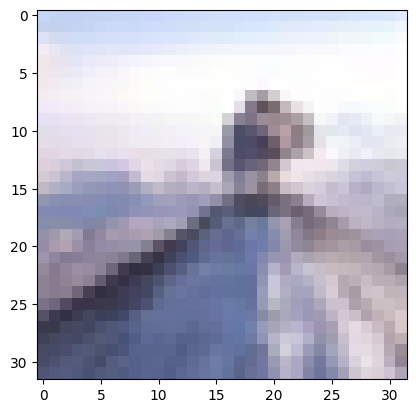

In [7]:
import matplotlib.pyplot as plt
plt.imshow((data_test[0]/255).reshape(3,32,32).transpose(1,2,0))

In [8]:
superclass_dict

{0: b'aquatic_mammals',
 1: b'fish',
 2: b'flowers',
 3: b'food_containers',
 4: b'fruit_and_vegetables',
 5: b'household_electrical_devices',
 6: b'household_furniture',
 7: b'insects',
 8: b'large_carnivores',
 9: b'large_man-made_outdoor_things',
 10: b'large_natural_outdoor_scenes',
 11: b'large_omnivores_and_herbivores',
 12: b'medium_mammals',
 13: b'non-insect_invertebrates',
 14: b'people',
 15: b'reptiles',
 16: b'small_mammals',
 17: b'trees',
 18: b'vehicles_1',
 19: b'vehicles_2'}

In [9]:
## cf cifar10
# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [10]:
# from classes import CIFAKE_loader
testdata = CI_LOADER(list(zip(data_test, label_test)), source='CIFAR100')
testdata_fine = CI_LOADER(list(zip(data_test, label_test_fine)), source='CIFAR100')

### Testing base model

In [11]:
# load model, test on test set
model = CIFAKE_CNN()
model.load_state_dict(torch.load(config['base_model']))

<All keys matched successfully>

In [12]:
len(testdata.batches)

313

In [13]:
gold, preds = test_model(model, testdata)
acc, eval = score_content_preds(gold, preds, superclass_dict)

  0%|          | 0/313 [00:00<?, ?it/s]


Performance (n=10000 test imgs, decision threshold=0.5)
Overall accuracy: 92.91%

                                   recall
b'aquatic_mammals'                  0.952
b'fish'                             0.962
b'flowers'                          0.882
b'food_containers'                  0.940
b'fruit_and_vegetables'             0.900
b'household_electrical_devices'     0.882
b'household_furniture'              0.950
b'insects'                          0.896
b'large_carnivores'                 0.928
b'large_man-made_outdoor_things'    0.948
b'large_natural_outdoor_scenes'     0.910
b'large_omnivores_and_herbivores'   0.956
b'medium_mammals'                   0.948
b'non-insect_invertebrates'         0.918
b'people'                           0.894
b'reptiles'                         0.934
b'small_mammals'                    0.950
b'trees'                            0.968
b'vehicles_1'                       0.920
b'vehicles_2'                       0.944


In [14]:
eval.describe()

,recall
count,20.000000
mean,0.929100
std,0.027125
min,0.882000
25%,0.907500
50%,0.937000
75%,0.950000
max,0.968000


In [15]:
find_extrema(eval)

(          recall
 b'trees'   0.968,
             recall
 b'flowers'   0.882)

In [16]:
gold, preds = test_model(model, testdata_fine)
acc_fine, eval_fine = score_content_preds(gold, preds, class_dict)

  0%|          | 0/313 [00:00<?, ?it/s]


Performance (n=10000 test imgs, decision threshold=0.5)
Overall accuracy: 92.91%

                  recall
b'apple'            0.91
b'aquarium_fish'    0.92
b'baby'             0.92
b'bear'             0.96
b'beaver'           0.94
...                  ...
b'whale'            0.90
b'willow_tree'      1.00
b'wolf'             0.98
b'woman'            0.84
b'worm'             0.94

[100 rows x 1 columns]


In [17]:
eval_fine.describe()

,recall
count,100.000000
mean,0.929100
std,0.045706
min,0.760000
25%,0.910000
50%,0.940000
75%,0.960000
max,1.000000


In [18]:
find_extrema(eval_fine)

(        recall
 b'ray'     1.0,
               recall
 b'butterfly'    0.76)

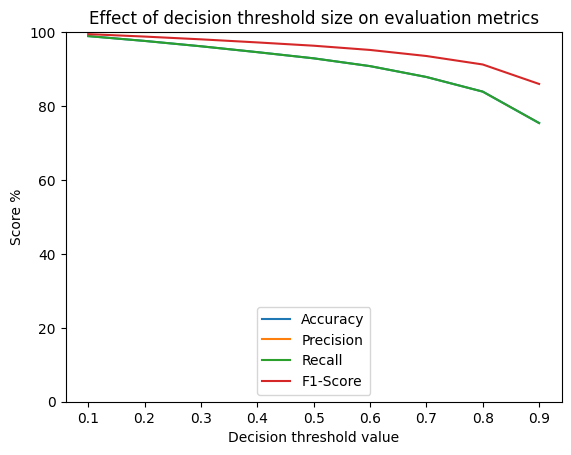

In [19]:
thresh_df_ci100 = test_thresh_size([1.0 for x in gold], preds)
visualise(thresh_df_ci100)


In [20]:
thresh_df_ci100

,Accuracy,Precision,Recall,F1-Score
0.1,98.92,100.0,98.92,99.457068
0.2,97.62,100.0,97.62,98.795668
0.3,96.17,100.0,96.17,98.047612
0.4,94.58,100.0,94.58,97.214513
0.5,92.91,100.0,92.91,96.324711
0.6,90.80,100.0,90.80,95.178197
0.7,87.86,100.0,87.86,93.537741
0.8,83.90,100.0,83.90,91.245242
0.9,75.40,100.0,75.40,85.974914


In [21]:
thresh_df_ci100.describe()

,Accuracy,Precision,Recall,F1-Score
count,9.000000,9.0,9.000000,9.000000
mean,90.906667,100.0,90.906667,95.086185
std,7.527744,0.0,7.527744,4.299315
min,75.400000,100.0,75.400000,85.974914
25%,87.860000,100.0,87.860000,93.537741
50%,92.910000,100.0,92.910000,96.324711
75%,96.170000,100.0,96.170000,98.047612
max,98.920000,100.0,98.920000,99.457068


### Comparison

### Mini

In [22]:
mini = CIFAKE_CNN()
mini.load_state_dict(torch.load(config['mini_model']))
mini.eval()
gold_mini, preds_mini = test_model(mini, testdata)
acc_mini, eval_mini = score_content_preds(gold_mini, preds_mini, superclass_dict)

  0%|          | 0/313 [00:00<?, ?it/s]


Performance (n=10000 test imgs, decision threshold=0.5)
Overall accuracy: 90.37%

                                   recall
b'aquatic_mammals'                  0.924
b'fish'                             0.928
b'flowers'                          0.654
b'food_containers'                  0.936
b'fruit_and_vegetables'             0.796
b'household_electrical_devices'     0.892
b'household_furniture'              0.914
b'insects'                          0.820
b'large_carnivores'                 0.922
b'large_man-made_outdoor_things'    0.944
b'large_natural_outdoor_scenes'     0.952
b'large_omnivores_and_herbivores'   0.968
b'medium_mammals'                   0.930
b'non-insect_invertebrates'         0.918
b'people'                           0.932
b'reptiles'                         0.930
b'small_mammals'                    0.984
b'trees'                            0.962
b'vehicles_1'                       0.854
b'vehicles_2'                       0.914


In [23]:
eval_mini.describe()

,recall
count,20.000000
mean,0.903700
std,0.074862
min,0.654000
25%,0.908500
50%,0.926000
75%,0.938000
max,0.984000


In [24]:
find_extrema(eval_mini)

(                  recall
 b'small_mammals'   0.984,
             recall
 b'flowers'   0.654)

In [25]:
gold_mini_fine, preds_mini_fine = test_model(mini, testdata_fine)
acc_mini_fine, eval_mini_fine = score_content_preds(
    gold_mini_fine, preds_mini_fine, class_dict)

  0%|          | 0/313 [00:00<?, ?it/s]


Performance (n=10000 test imgs, decision threshold=0.5)
Overall accuracy: 90.37%

                  recall
b'apple'            0.94
b'aquarium_fish'    0.86
b'baby'             0.95
b'bear'             0.98
b'beaver'           0.99
...                  ...
b'whale'            0.84
b'willow_tree'      1.00
b'wolf'             0.99
b'woman'            0.94
b'worm'             0.91

[100 rows x 1 columns]


In [26]:
eval_mini_fine.describe()

,recall
count,100.00000
mean,0.90370
std,0.10655
min,0.35000
25%,0.87500
50%,0.94000
75%,0.97250
max,1.00000


In [27]:
find_extrema(eval_mini_fine)

(               recall
 b'chimpanzee'     1.0,
               recall
 b'sunflower'    0.35)

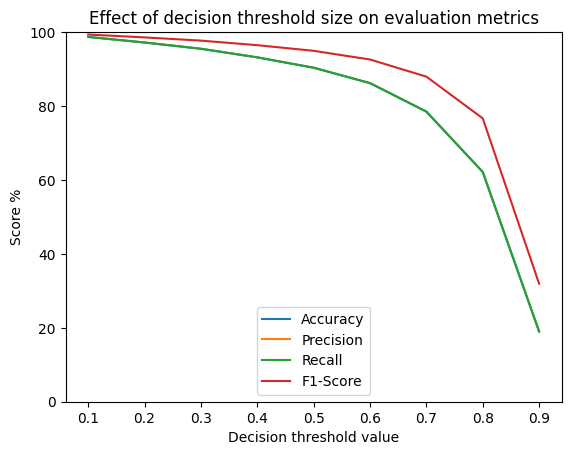

In [28]:
thresh_df_ci100_mini = test_thresh_size([1.0 for x in gold_mini], preds_mini)
visualise(thresh_df_ci100_mini)


### Attention model

In [29]:
attn = CIFAKE_CNN(attn=True)
attn.load_state_dict(torch.load(config['attn_model']))
gold_attn, preds_attn = test_model(attn, testdata)
acc_attn, eval_attn = score_content_preds(gold_attn, preds_attn, superclass_dict)

  0%|          | 0/313 [00:00<?, ?it/s]


Performance (n=10000 test imgs, decision threshold=0.5)
Overall accuracy: 91.31%

                                   recall
b'aquatic_mammals'                  0.940
b'fish'                             0.954
b'flowers'                          0.870
b'food_containers'                  0.898
b'fruit_and_vegetables'             0.904
b'household_electrical_devices'     0.872
b'household_furniture'              0.924
b'insects'                          0.876
b'large_carnivores'                 0.948
b'large_man-made_outdoor_things'    0.924
b'large_natural_outdoor_scenes'     0.838
b'large_omnivores_and_herbivores'   0.942
b'medium_mammals'                   0.934
b'non-insect_invertebrates'         0.906
b'people'                           0.904
b'reptiles'                         0.930
b'small_mammals'                    0.972
b'trees'                            0.948
b'vehicles_1'                       0.878
b'vehicles_2'                       0.900


In [30]:
eval_attn.describe()

,recall
count,20.000000
mean,0.913100
std,0.034418
min,0.838000
25%,0.893000
50%,0.915000
75%,0.940500
max,0.972000


In [31]:
find_extrema(eval_attn)

(                  recall
 b'small_mammals'   0.972,
                                  recall
 b'large_natural_outdoor_scenes'   0.838)

In [32]:
gold_attn_fine, preds_attn_fine = test_model(attn, testdata_fine)
acc_attn_fine, eval_attn_fine = score_content_preds(
    gold_attn_fine, preds_attn_fine, class_dict)

  0%|          | 0/313 [00:00<?, ?it/s]


Performance (n=10000 test imgs, decision threshold=0.5)
Overall accuracy: 91.31%

                  recall
b'apple'            0.94
b'aquarium_fish'    0.95
b'baby'             0.93
b'bear'             0.97
b'beaver'           0.93
...                  ...
b'whale'            0.86
b'willow_tree'      0.98
b'wolf'             0.98
b'woman'            0.91
b'worm'             0.89

[100 rows x 1 columns]


In [33]:
eval_attn_fine.describe()

,recall
count,100.000000
mean,0.913100
std,0.060364
min,0.620000
25%,0.890000
50%,0.930000
75%,0.950000
max,0.990000


In [34]:
find_extrema(eval_attn_fine)

(           recall
 b'castle'    0.99,
         recall
 b'sea'    0.62)

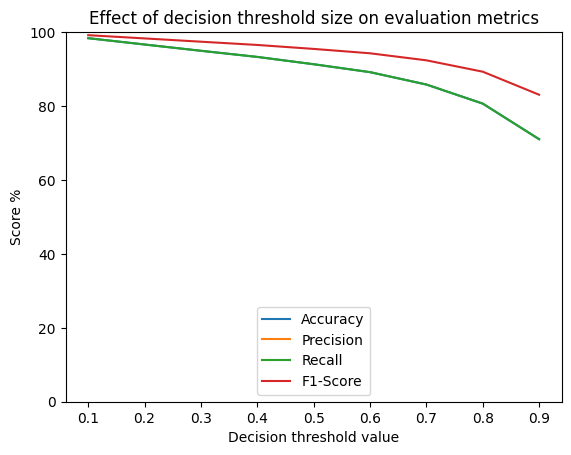

In [35]:
thresh_df_ci100_attn = test_thresh_size([1.0 for x in gold_attn], preds_attn)
visualise(thresh_df_ci100_attn)